<a href="https://colab.research.google.com/github/ArySuby/sasap-test/blob/main/ProyectoDSParteI_Suby_MercadoLibreAutosMdP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final - Parte I
**Curso:** Data Science - Coderhouse  
**Alumno:** Ary Suby  
**Tema:** Estimación de precios de autos usados en Mar del Plata (MercadoLibre)

## 📄 Resumen

Este proyecto se centra en el análisis de autos usados publicados en la ciudad de Mar del Plata a través de MercadoLibre, con el objetivo de construir un modelo que permita estimar el precio en dólares estadounidenses (USD) en función de atributos relevantes como marca, modelo, año y kilometraje.

Para ello se desarrolló un proceso de scraping utilizando Playwright, junto con una rutina de limpieza de datos y normalización de precios a dólar oficial. A partir del dataset generado, se exploraron visualmente las variables con mayor impacto en los precios, y se aplicaron filtros para quedarnos con un subconjunto de datos representativo y de buena calidad (modelos frecuentes, autos desde 2010, precios y kilometrajes razonables).

Con este dataset filtrado, se realizaron visualizaciones univariadas y multivariadas para comprender las relaciones entre variables. Finalmente, se entrenó un modelo de regresión lineal con OneHotEncoding sobre variables categóricas, obteniendo un R² razonable y errores dentro de márgenes esperables. Este modelo se aplicó posteriormente sobre un dataset externo (concesionaria TiendaCars) para predecir precios automáticamente.

---

## ❓ Preguntas e hipótesis

- ¿Qué marcas y modelos tienen mayor presencia en el mercado de usados de Mar del Plata?
- ¿Cómo varía el precio según el año del vehículo y su kilometraje?
- ¿Existen marcas que tienden a retener mejor su valor?
- Hipótesis 1: A menor kilometraje y mayor año, mayor es el precio del auto.
- Hipótesis 2: Algunos modelos populares presentan una menor depreciación relativa.

In [1]:
!pip install beautifulsoup4
!pip install playwright
!playwright install chromium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 18.6 MB/s eta 0:00:00
171.6 MiB [] 0% 0.0s171.6 MiB [] 0% 50.1s171.6 MiB [] 0% 24.7s171.6 MiB [] 0% 14.4s171.6 MiB [] 0% 8.4s171.6 MiB [] 1% 5.7s171.6 MiB [] 2% 4.5s171.6 MiB [] 3% 3.5s171.6 MiB [] 4% 3.0s171.6 MiB [] 4% 2.8s171.6 MiB [] 5% 3.2s171.6 MiB [] 6% 2.8s171.6 MiB [] 7% 2.7s171.6 MiB [] 7% 2.6s171.6 MiB [] 8% 2.6s171.6 MiB [] 9% 2.5s171.6 MiB [] 9% 2.6s171.6 MiB [] 10% 2.4s171.6 MiB [] 10% 2.5s171.6 MiB [] 11% 2.4s171.6 MiB [] 12% 2.3s171.6 MiB [] 14% 2.2s171.6 MiB [] 15% 2.1s171.6 MiB [] 15% 2.0s171.6 MiB [] 16% 2.0s171.6 MiB [] 17% 1.9s171.6 MiB [] 18% 1.9s171.6 MiB [] 19% 1.8s171.6 MiB [] 20% 1.8s171.6 MiB [] 21% 1.8s171.6 MiB [] 22% 1.9s171.6 MiB [] 23% 1.8s171.6 MiB [] 25% 1.7s171.6 MiB [] 26% 1.6s171.6 MiB [] 27% 1.6s171.6 MiB [] 28% 1.5s171.6 MiB [] 30% 1.5s171.6 MiB [] 31% 1.4s171.6 MiB [] 32% 1.4s171.6 MiB [] 33% 1.3s171.6 MiB [] 34% 1.3s171.6 MiB [] 35% 1.3s171.6 MiB [] 37% 1.2s171.6 MiB [] 38% 1.2s171.6 MiB [

Una vez corrido este codigo, me pude guardar un dataset con los datos que extraje "autos_ml_mar_del_plata_usd.csv", pero de un dia para el otro el codigo se rompio (no se si fue porque mercado libre detecto el scrapping, o por alguna otra razon que desconozco) pero ya no corre y no pude resolverlo. Intente de muchas maneras y no hay caso. Por suerte descargue y guarde el archivo que si funciono y que adjunto en el trabajo para que en la siguiente linea de codigo lo puedan usar para seguir con las visualizaciones.

In [2]:
import asyncio
import nest_asyncio
from playwright.async_api import async_playwright
import pandas as pd
import requests

nest_asyncio.apply()

# Obtener dólar oficial
def obtener_dolar_oficial():
    try:
        url = "https://api.bluelytics.com.ar/v2/latest"
        resp = requests.get(url, timeout=10)
        data = resp.json()
        oficial = data.get("oficial") or data.get("official")
        if oficial and "value_sell" in oficial:
            return float(oficial["value_sell"])
    except Exception as e:
        print(f"Error al obtener dólar oficial Bluelytics: {e}")
    return None

# Scraping paginado por _Desde_N
async def scrapear_autos():
    base_url = "https://autos.mercadolibre.com.ar/bsas-costa-atlantica/mar-del-plata/usados/_Desde_{}"
    autos = []
    offset = 0
    page_size = 48

    async with async_playwright() as pw:
        browser = await pw.chromium.launch(headless=True)
        page = await browser.new_page()

        while True:
            print(f"Scrapeando página con offset {offset}...")
            url = base_url.format(offset)
            await page.goto(url, wait_until='domcontentloaded')
            await page.wait_for_timeout(3000)

            items = await page.query_selector_all("li.ui-search-layout__item")
            if not items:
                break  # fin de resultados

            for el in items:
                try:
                    title = await el.eval_on_selector("h2, h3", "e => e.textContent.trim()")
                    num = await el.eval_on_selector("span.andes-money-amount__fraction", "e => e.textContent.trim()")
                    sym = await el.eval_on_selector("span.andes-money-amount__currency-symbol", "e => e.textContent.trim()")
                except:
                    continue

                attrs = await el.query_selector_all("ul.poly-attributes_list li")
                year = km = None
                for at in attrs:
                    txt = (await at.inner_text()).strip()
                    if txt.isdigit() and len(txt) == 4:
                        year = txt
                    elif "km" in txt.lower():
                        km = txt

                marca = title.split()[0]
                modelo = " ".join(title.split()[1:])

                autos.append({
                    "marca": marca,
                    "modelo": modelo,
                    "año": year,
                    "kilometraje": km,
                    "precio_orig": int(num.replace(".", "")),
                    "moneda": sym
                })

            offset += page_size  # siguiente página

        await browser.close()
    return autos

# Ejecutar todo
autos = asyncio.get_event_loop().run_until_complete(scrapear_autos())

dolar_oficial = obtener_dolar_oficial()
print(f"Dólar oficial (venta, BNA vía Bluelytics): {dolar_oficial}")

# Normalizar precios
for auto in autos:
    if auto["moneda"] == "US$":
        auto["precio_usd"] = auto["precio_orig"]
    elif auto["moneda"] == "$" and dolar_oficial:
        auto["precio_usd"] = round(auto["precio_orig"] / dolar_oficial, 2)
    else:
        auto["precio_usd"] = None

# Guardar CSV
df = pd.DataFrame(autos)
df.to_csv("autos_ml_mar_del_plata_usd.csv", index=False)
print(f"✅ Total autos scrapeados: {len(df)}")
print(df.head())


Scrapeando página con offset 0...
Dólar oficial (venta, BNA vía Bluelytics): 1277.0
✅ Total autos scrapeados: 0
Empty DataFrame
Columns: []
Index: []


Una vez extraidos los autos usados en mar del plata de mercado libre, con sus respectivos precios en dolares, marca, modelo, kilometraje y año, se prosiguio con la limpieza de los mismos. Se aplicaron filtros para asegurarnos que sean autos usados, como km > 0, precio en dolares entre 3000 y 60000, y seleccione los autos que sean usados pero del 2010 en adelante.

In [3]:
# Leer el CSV previo
df = pd.read_csv("autos_ml_mar_del_plata_usd.csv")

# Convertir columnas a tipo adecuado
df["año"] = pd.to_numeric(df["año"], errors="coerce")

# Extraer números del kilometraje y convertir a int
df["kilometraje"] = df["kilometraje"].str.replace(".", "", regex=False)  # sacamos puntos
df["kilometraje"] = pd.to_numeric(df["kilometraje"].str.extract(r"(\d+)")[0], errors="coerce")

# Convertir precio_usd a num (por si acaso)
df["precio_usd"] = pd.to_numeric(df["precio_usd"], errors="coerce")

# Aplicar filtros
df_filtrado = df[
    (df["año"] >= 2010) &
    (df["año"] <= 2025) &
    (df["kilometraje"] > 0) &
    (df["precio_usd"] >= 3000) &
    (df["precio_usd"] <= 60000)
].copy()

# Guardar nuevo CSV
df_filtrado.to_csv("autos_ml_mar_del_plata_usd_filtrado.csv", index=False)

print(f"Autos después de filtrar: {len(df_filtrado)}")
print(df_filtrado.head())

Autos después de filtrar: 1789
           marca                                     modelo     año  \
0        Renault                   Captur 2.0 Intens Manual  2017.0   
1  Mercedes-benz  Clase Glk 3.0 Glk300 4matic City 231cv At  2013.0   
2         Toyota                     Etios 1.5 Sedan Xls At  2019.0   
3  Mercedes-benz             Clase Glc Glc 300 Coupé 4matic  2017.0   
4           Ford                  Focus Iii 2.0 Se Plus At6  2015.0   

   kilometraje  precio_orig moneda  precio_usd  
0        80000     21000000      $    17241.38  
1       155000        19900    US$    19900.00  
2        90000     20000000      $    16420.36  
3        80000        59900    US$    59900.00  
4        90000     17300000      $    14203.61  


/tmp/ipython-input-4-1299733836.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_marcas.values, y=top_marcas.index, palette="viridis")


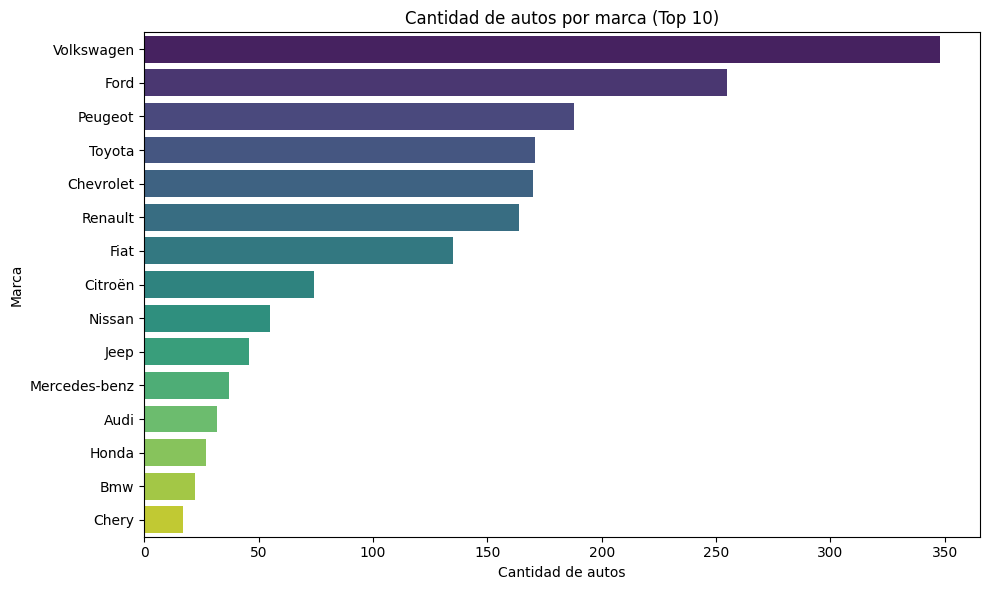

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset (ajustar path si hace falta)
df = pd.read_csv("autos_ml_mar_del_plata_usd_filtrado.csv")

# Contar autos por marca
conteo_marcas = df['marca'].value_counts()

# Mostrar las 10 marcas más comunes
top_marcas = conteo_marcas.head(15)

# Gráfico
plt.figure(figsize=(10,6))
sns.barplot(x=top_marcas.values, y=top_marcas.index, palette="viridis")
plt.title("Cantidad de autos por marca (Top 10)")
plt.xlabel("Cantidad de autos")
plt.ylabel("Marca")
plt.tight_layout()
plt.show()

Aca se decidio seleccionar las marcas que tengan mas de 50 autos, si no el modelo iba a tener para entrenar marcas con muy pocos ejemplos e iba a generar malos resultados.

In [5]:
# Cargar el dataset
df = pd.read_csv("autos_ml_mar_del_plata_usd_filtrado.csv")

# Contar cuántos autos hay por marca
conteo_marcas = df['marca'].value_counts()

# Seleccionar solo marcas con más de 50 autos
marcas_validas = conteo_marcas[conteo_marcas > 50].index

# Filtrar el DataFrame
df_filtrado = df[df['marca'].isin(marcas_validas)].copy()

# Guardar el nuevo archivo
df_filtrado.to_csv("autos_ml_mar_del_plata_usd_filtrado_marcas.csv", index=False)

# Mostrar resumen
print("Total de autos después del filtrado:", len(df_filtrado))
print("Marcas incluidas:", list(df_filtrado['marca'].unique()))


Total de autos después del filtrado: 1560
Marcas incluidas: ['Renault', 'Toyota', 'Ford', 'Chevrolet', 'Volkswagen', 'Fiat', 'Peugeot', 'Nissan', 'Citroën']


En esta seccion del codigo se unificaron los criterios para los modelos de los autos. Habian distintas formas de escribir un mismo modelo, por ejemplo Ford Ka 1.5 Se, Ford Ka 1.5 S, Ford Ka 1.5 Sel.

In [6]:
df = pd.read_csv("autos_ml_mar_del_plata_usd_filtrado_marcas.csv")

# Función para limpiar y simplificar modelo
def simplificar_modelo(texto, palabras=2):
    if pd.isna(texto):
        return texto
    partes = texto.split()
    return " ".join(partes[:palabras])  # primeras 2 palabras

# Aplicar simplificación
df["modelo_simple"] = df["modelo"].apply(lambda x: simplificar_modelo(x, palabras=2))

# Ver cuántos modelos únicos quedan
print(f"Modelos únicos antes: {df['modelo'].nunique()}")
print(f"Modelos únicos después: {df['modelo_simple'].nunique()}")

# Guardar archivo con modelos simplificados
df.to_csv("autos_ml_mar_del_plata_usd_limpio.csv", index=False)

Modelos únicos antes: 845
Modelos únicos después: 267


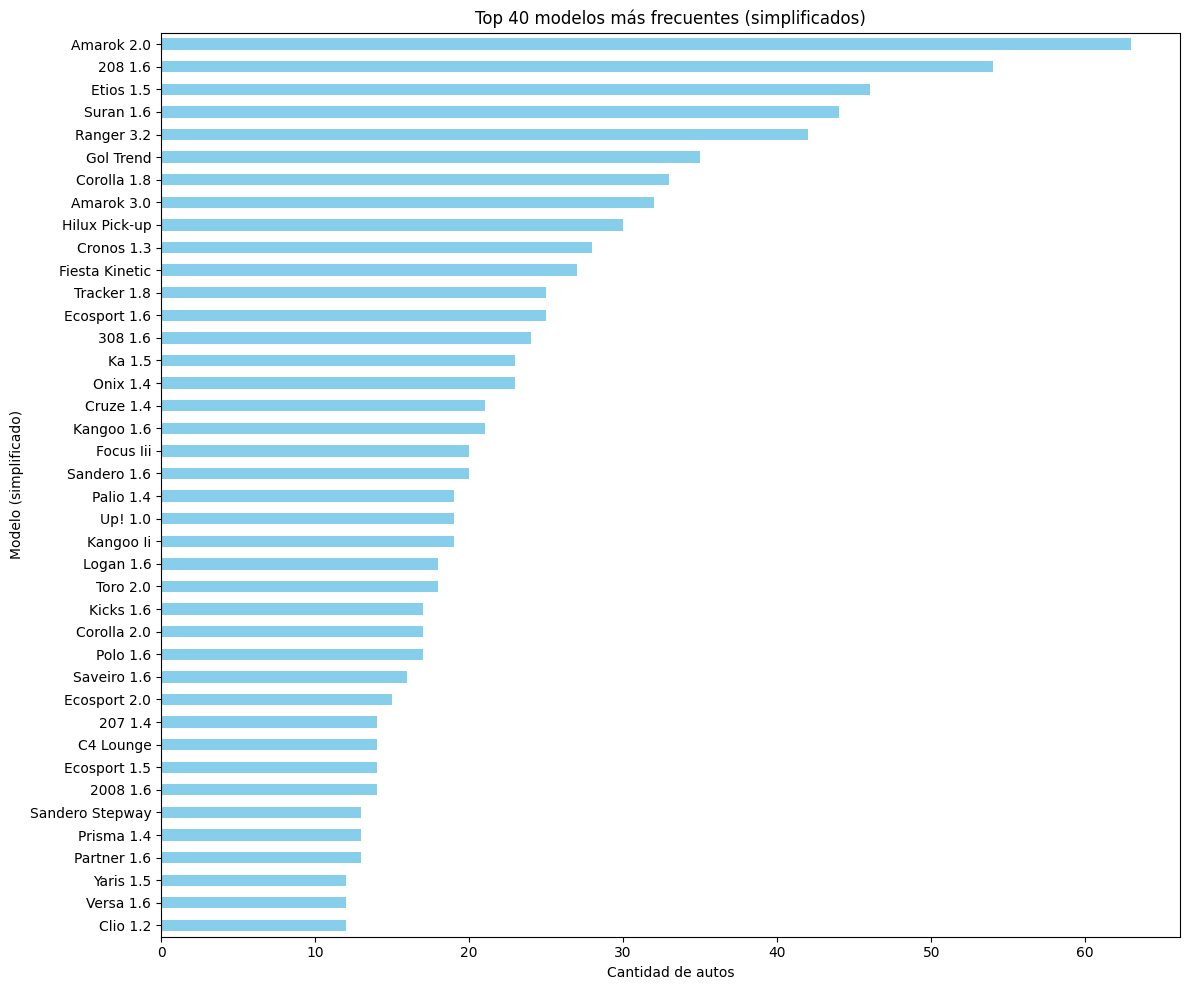

Los 40 modelos más frecuentes representan el 60.38% del total (942 de 1560 autos).


In [7]:
# Cargar el archivo con modelos simplificados
df = pd.read_csv("autos_ml_mar_del_plata_usd_limpio.csv")

# Contar frecuencia de modelos simplificados
conteo_modelos = df["modelo_simple"].value_counts().head(40)

# Gráfico
plt.figure(figsize=(12, 10))
conteo_modelos.sort_values().plot(kind="barh", color="skyblue")
plt.title("Top 40 modelos más frecuentes (simplificados)")
plt.xlabel("Cantidad de autos")
plt.ylabel("Modelo (simplificado)")
plt.tight_layout()
plt.show()

# Total de autos en el dataset
total_autos = len(df)

# Total de autos representados por los 40 modelos más frecuentes
autos_top_40_modelos = conteo_modelos.sum()

# Porcentaje que representan
porcentaje = autos_top_40_modelos / total_autos * 100

print(f"Los 40 modelos más frecuentes representan el {porcentaje:.2f}% del total ({autos_top_40_modelos} de {total_autos} autos).")

Decido quedarme con los 40 modelos mas frecuentes de autos en el mercado, siendo 942 autos de los 1560 que habian sido filtrados preliminarmente. Esta decision la tome pensando en la mejora de mi modelo. Si usaba modelos de autos que tengan solo 3 datos, seguro iba a generar ruido en el modelo e iba a estimar precios con muy pocos datos.  

In [8]:
# Cargar dataset limpio
df = pd.read_csv("autos_ml_mar_del_plata_usd_limpio.csv")

# Obtener los 40 modelos más frecuentes (columna modelo_simple)
modelos_top40 = df["modelo_simple"].value_counts().head(40).index.tolist()

# Filtrar el DataFrame
df_modelos_top40 = df[df["modelo_simple"].isin(modelos_top40)].copy()

# Guardar a CSV
df_modelos_top40.to_csv("autos_ml_mdp_modelos_top40.csv", index=False)

# Verificar
print(f"Autos seleccionados: {len(df_modelos_top40)}")
print(f"Modelos incluidos: {sorted(modelos_top40)}")

Autos seleccionados: 942
Modelos incluidos: ['2008 1.6', '207 1.4', '208 1.6', '308 1.6', 'Amarok 2.0', 'Amarok 3.0', 'C4 Lounge', 'Clio 1.2', 'Corolla 1.8', 'Corolla 2.0', 'Cronos 1.3', 'Cruze 1.4', 'Ecosport 1.5', 'Ecosport 1.6', 'Ecosport 2.0', 'Etios 1.5', 'Fiesta Kinetic', 'Focus Iii', 'Gol Trend', 'Hilux Pick-up', 'Ka 1.5', 'Kangoo 1.6', 'Kangoo Ii', 'Kicks 1.6', 'Logan 1.6', 'Onix 1.4', 'Palio 1.4', 'Partner 1.6', 'Polo 1.6', 'Prisma 1.4', 'Ranger 3.2', 'Sandero 1.6', 'Sandero Stepway', 'Saveiro 1.6', 'Suran 1.6', 'Toro 2.0', 'Tracker 1.8', 'Up! 1.0', 'Versa 1.6', 'Yaris 1.5']


Modelo de regresion lineal. Variables a usar fueron marca, modelo simplificado, año y kilometraje. Se busco estimar el precio del auto en dolares.

In [28]:
# 1. Importar librerías
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 2. Cargar el dataset
df = pd.read_csv('autos_ml_mdp_modelos_top40.csv')

# ✅ Crear columna numérica para kilometraje
df['kilometraje_num'] = df['kilometraje']

# 3. Variables a usar
features = ['marca', 'modelo_simple', 'año', 'kilometraje_num']
target = 'precio_usd'

# 4. Eliminar filas con valores faltantes
df = df.dropna(subset=features + [target])

# 5. Separar X e y
X = df[features]
y = df[target]

# 6. Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Codificación para variables categóricas
categorical_features = ['marca', 'modelo_simple']
numeric_features = ['año', 'kilometraje_num']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

# 8. Pipeline con regresión lineal
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 9. Entrenar modelo
model.fit(X_train, y_train)

# 10. Evaluar
y_pred = model.predict(X_test)
print(f"R²: {r2_score(y_test, y_pred):.3f}")
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:,.2f} USD")

R²: 0.870
RMSE: 2,807.67 USD


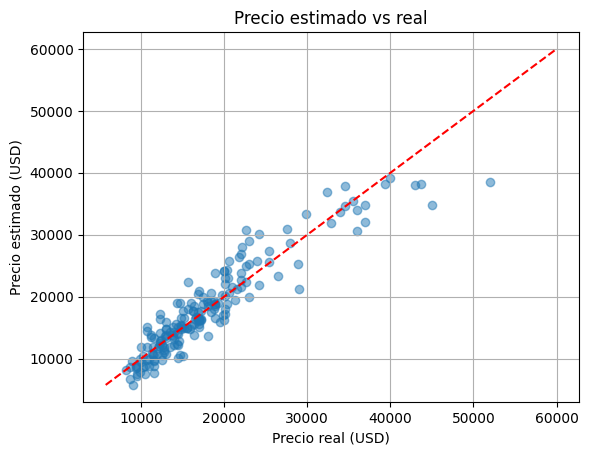

In [22]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Precio real (USD)")
plt.ylabel("Precio estimado (USD)")
plt.title("Precio estimado vs real")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.grid(True)
plt.show()

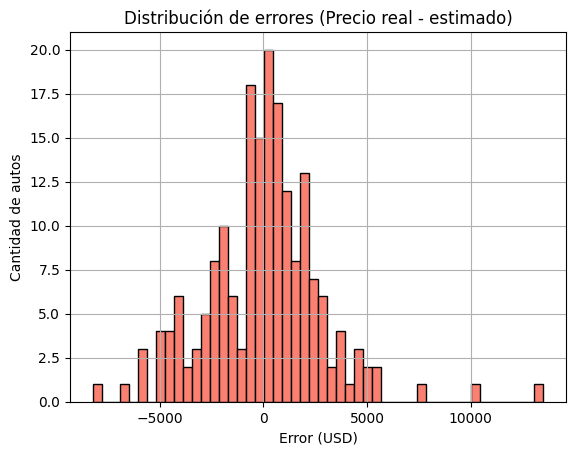

In [23]:
errors = y_test - y_pred
plt.hist(errors, bins=50, color="salmon", edgecolor="black")
plt.title("Distribución de errores (Precio real - estimado)")
plt.xlabel("Error (USD)")
plt.ylabel("Cantidad de autos")
plt.grid(True)
plt.show()

In [29]:
import joblib

# Guardar el modelo entrenado en un archivo
joblib.dump(model, 'modelo_autos.pkl')

# Más adelante o en otro script, cargar el modelo
modelo_cargado = joblib.load('modelo_autos.pkl')

In [31]:
import pandas as pd
import numpy as np
import joblib

# 1. Cargar modelo entrenado
model = joblib.load("modelo_autos.pkl")

# 2. Cargar dataset Tienda Cars
df_tienda = pd.read_csv("tiendacars_autos_filtrado.csv")

# 3. Renombrar columnas para que coincidan con el modelo
df_tienda = df_tienda.rename(columns={
    "Marca": "marca",
    "Modelo": "modelo",
    "Año": "año",
    "Kilómetros": "kilometraje"
})

# 4. Crear columnas necesarias para el modelo
df_tienda["kilometraje_num"] = df_tienda["kilometraje"]
df_tienda["año"] = pd.to_numeric(df_tienda["año"], errors="coerce")

# Función para simplificar modelo a primeras 2 palabras
def simplificar_modelo(texto, palabras=2):
    if pd.isna(texto):
        return texto
    partes = texto.split()
    return " ".join(partes[:palabras])

df_tienda["modelo_simple"] = df_tienda["modelo"].apply(lambda x: simplificar_modelo(x, palabras=2))

# 5. Filtrar filas sin valores faltantes en las columnas que usaremos
df_modelo = df_tienda[["marca", "modelo_simple", "año", "kilometraje_num"]].copy()
df_modelo = df_modelo.dropna()

# 6. Crear la columna 'kilometraje_log' que espera el modelo
df_modelo['kilometraje_log'] = np.log1p(df_modelo['kilometraje_num'])

# 7. Seleccionar columnas que pide el pipeline para predecir
X_pred = df_modelo[['marca', 'modelo_simple', 'año', 'kilometraje_num']]

# 8. Generar predicciones
predicciones = np.round(model.predict(X_pred)).astype(int)

# 9. Guardar las predicciones en el DataFrame original (en las filas correspondientes)
df_tienda.loc[df_modelo.index, 'precio_estimado_usd'] = predicciones

# 10. Guardar a CSV con las predicciones
df_tienda.to_csv("tiendacars_autos_con_predicciones.csv", index=False)

print("Predicciones generadas y guardadas en 'tiendacars_autos_con_predicciones.csv'")
print(df_tienda.loc[df_modelo.index, ["marca", "modelo_simple", "año", "kilometraje_num", "precio_estimado_usd"]].head(20))

Predicciones generadas y guardadas en 'tiendacars_autos_con_predicciones.csv'
         marca modelo_simple   año  kilometraje_num  precio_estimado_usd
0         Fiat        Cronos  2023            45244              21346.0
1       Nissan         Kicks  2024             8000              24529.0
2         Ford      Ecosport  2020            61000              19942.0
3         Fiat        Cronos  2023            59698              21159.0
4   Volkswagen          Taos  2022            93500              23352.0
5       Toyota         Yaris  2023            62492              26983.0
6       Toyota         Yaris  2023            62876              26978.0
7   Volkswagen        Amarok  2023            58755              24778.0
8   Volkswagen       T-Cross  2020           112777              21148.0
9      Renault         Logan  2023            40524              20182.0
10      Nissan       X-trail  2018            92320              17577.0
11        Fiat        Cronos  2024            